In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import torch 
import pandas as pd
import os
from PIL import Image
from PIL import Image, ImageOps
import scipy.ndimage


/home/shilpi_fire/colab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/role_challenge_dataset_ground_truth.csv')
images = os.listdir('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/')
print(data.shape, len(images))
data.head(4)


(622, 9) 622


,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363


In [3]:
#check all input image sizes 
base_path = '/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/'
image_paths = os.listdir(base_path) 
s = set()
for image_path in image_paths: 
      actual_path = os.path.join(base_path, image_path) 
      with Image.open(actual_path).convert('L') as img: #l is for grayscale mode
            original_shape = img.size
            # print(original_shape)
            s.add(original_shape)
print(s)

{(794, 544), (790, 539), (797, 541), (800, 540), (780, 544), (794, 543), (783, 543), (799, 563), (738, 541), (788, 545), (786, 542), (800, 542), (780, 539), (782, 542), (783, 541)}


original_image.size:  (800, 540)


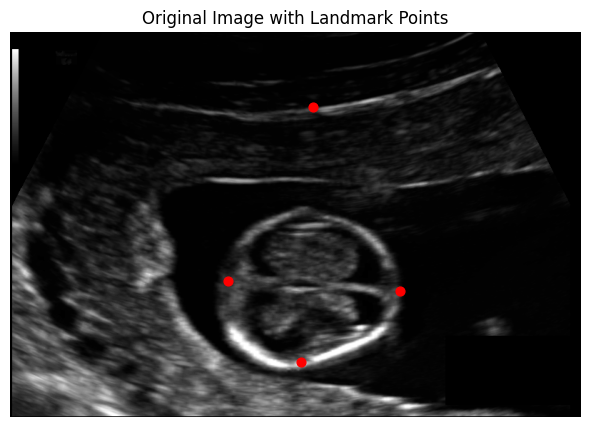

In [4]:
#take a look at the data given: plot original coordinates on original image 
def visualize_individual_points(image, coordinates):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray', aspect='equal')
    for coord in coordinates:
        x, y = coord
        x, y = int(x), int(y)  # Ensure coordinates are integers
        plt.scatter([x], [y], c='r', s=40)
    plt.title("Original Image with Landmark Points")
    plt.axis('off')
    plt.show()

original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/003_HC.png').convert('L')
print('original_image.size: ', original_image.size) 
image = np.array(original_image)/ 255.0 #normalizing
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)] #wrote myself
visualize_individual_points(image, my_coord)

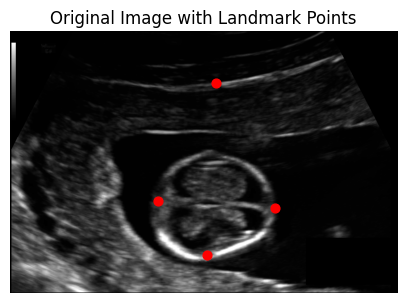

In [5]:
#this shows that noramlization works well, we'lls ee later
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the functions for normalization and scaling
def normalize_coordinates(coordinates, image_size):
    normalized_coords = [(x / image_size[0], y / image_size[1]) for x, y in coordinates]
    return normalized_coords

def scale_coordinates(norm_coords, image_size):
    scaled_coords = [(int(x * image_size[0]), int(y * image_size[1])) for x, y in norm_coords]
    return scaled_coords

# Define the visualization function
def visualize_individual_points(image, coordinates):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    for x, y in coordinates:
        plt.scatter([x], [y], c='r', s=40)
    plt.title("Original Image with Landmark Points")
    plt.axis('off')
    plt.show()

# Assume we have an original image and coordinates
original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/003_HC.png').convert('L')
original_image_size = original_image.size  # Width, Height
coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]

# Normalize the coordinates
normalized_coordinates = normalize_coordinates(coordinates, original_image_size)

# If you were to resize the image, you would then scale the normalized coordinates
# For demonstration, let's say we keep the original image size
scaled_coordinates = scale_coordinates(normalized_coordinates, original_image_size)

# Convert image to array and normalize pixel values
image_array = np.array(original_image) / 255.0

# Visualize the scaled coordinates on the original (or resized) image
visualize_individual_points(image_array, scaled_coordinates)


It seems the given annotated images are not properly annotated which could lead to bad training and test accuracy. 

original_image.size:  (800, 540)


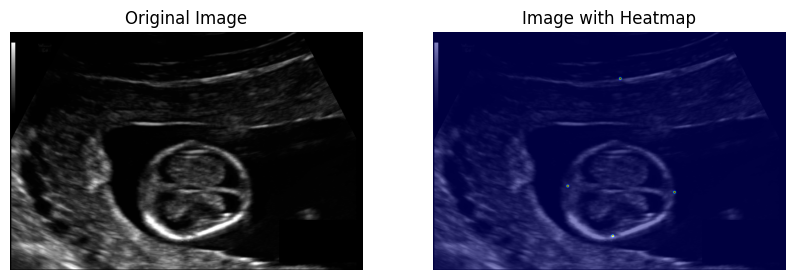

In [22]:
#try creating heatmaps and plotting it 
def create_heatmap(coords, image_shape, sigma=2):
    # print('inside heatmap, shape: ', image_shape)
    heatmap = np.zeros(image_shape, dtype=np.float32)  # Initialize heatmap
    # print('initiallly, heatmap.size: ', heatmap.size)
    for x, y in coords:
        if y < image_shape[0] and x < image_shape[1]:
            heatmap[y, x] = 1  # Mark the landmark position with a 1
    heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma=sigma)
    return heatmap

def visualize_image_and_heatmap(image, heatmap):
    # if image.shape != heatmap.shape:
    # if image.size != heatmap.size: 
    #     print(image.size, heatmap.size, 'these are the values.')
    #     raise ValueError(f"Image and heatmap shapes do not match: {image.size} vs {heatmap.size}")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', aspect = 'equal')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap, alpha=0.5, cmap='jet', aspect='equal')  # Overlay heatmap
    plt.title("Image with Heatmap")
    plt.axis('off')
    # ax.set_xlim([0, image.shape[1]])
    # ax.set_ylim([image.shape[0], 0])  
    plt.show()

original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/003_HC.png').convert('L')
print('original_image.size: ', original_image.size) 
image = np.array(original_image)/ 255.0 #normalizing
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)] #wrote myself
heatmap = create_heatmap(my_coord,(original_image.size[1], original_image.size[0])) #these values are not scaled at all. 
visualize_image_and_heatmap(image, heatmap) 

it seems some images are indeed annotated wrong, as it shows even in the heatmaps

In [7]:
#check if there are any nulll values in any of the features 
cols = [col for col in data.columns if data[col].isnull().any()]
print(cols) #no null values anywhere

[]


In [8]:
#converting coordinates into tuples to feed into heatmap function 
all_coordinates = []
for index, row in data.iterrows():
    ofd_1 = (row['ofd_1_x'], row['ofd_1_y'])
    ofd_2 = (row['ofd_2_x'], row['ofd_2_y'])
    bpd_1 = (row['bpd_1_x'], row['bpd_1_y'])
    bpd_2 = (row['bpd_2_x'], row['bpd_2_y'])
    coordinates = [ofd_1, ofd_2, bpd_1, bpd_2]
    all_coordinates.append(coordinates)

/tmp/ipykernel_4842/3280817827.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


scaled_coordinates:  [(135, 74), (130, 189), (97, 152), (175, 157)]


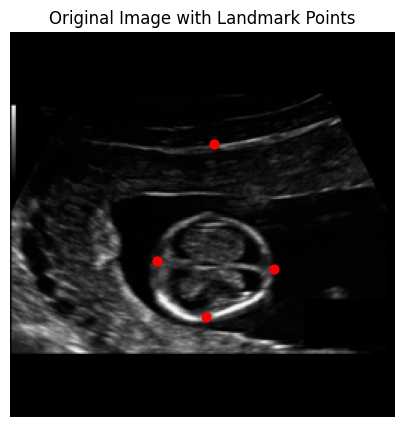

In [24]:
#works 
def resize_image_with_padding(img, target_size):
    # Calculate the size preserving aspect ratio
    aspect_ratio = img.width / img.height
    if target_size[0] / target_size[1] > aspect_ratio:
        new_height = target_size[1]
        new_width = round(new_height * aspect_ratio)
    else:
        new_width = target_size[0]
        new_height = round(new_width / aspect_ratio)

    # Resize the image preserving aspect ratio
    resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    # Create a new image with the given size and black background
    padded_image = Image.new('L', target_size, 0)
    
    # Paste the resized image into center of the black background
    padding_top = (target_size[1] - new_height) // 2
    padding_left = (target_size[0] - new_width) // 2
    padded_image.paste(resized_image, (padding_left, padding_top))

    return padded_image, (padding_left, padding_top, new_width, new_height)

def scale_coordinates(coords, original_size, padding_info, target_size):
    # Unpack padding info
    padding_left, padding_top, new_width, new_height = padding_info
    # print('new_width (inside scale_cooords): ', new_width, 'new)height:(inside_scale_coords) ', new_height) 
    # print('target_size: ', target_size)
    # Calculate the scaling factors
    x_scale = new_width / original_size[0]
    y_scale = new_height / original_size[1]

    # Apply scaling factors and offset by the padding
    scaled_coords = [(int(x * x_scale + padding_left), int(y * y_scale + padding_top)) for x, y in coords]

    return scaled_coords
# def previous_wrong_scale_coordinates(coords, original_shape, padding, target_size):
#     # Normalize the coordinates
#     normalized_coords = [(x / original_shape[0], y / original_shape[1]) for x, y in coords]
    
#     # Scale the normalized coordinates to the target size
#     scaled_coords = [(int(x * target_size[0] + padding[0]), int(y * target_size[1] + padding[1])) for x, y in normalized_coords]
    
#     return scaled_coords
original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/003_HC.png').convert('L')
target_size = (256, 256)  # The desired output size
# Resize image and get padding offsets
resized_image, padding_info= resize_image_with_padding(original_image, target_size)
original_coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]
scaled_coordinates = scale_coordinates(original_coordinates, original_image.size, padding_info, target_size)
print('scaled_coordinates: ', scaled_coordinates)
# visualize_individual_points(original_image, original_coordinates)
visualize_individual_points(resized_image, scaled_coordinates)

Data being used is very bad and you can't achieve high accuracy with this data.

original_img.szie:  (800, 540)
resized_image.size:  (256, 256)
new_width (inside scale_cooords):  256 new)height:(inside_scale_coords)  173
target_size:  (256, 256)
inside heatmap, shape:  (256, 256)
initiallly, heatmap.size:  65536
resized and scaled: 


/tmp/ipykernel_4842/566063663.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


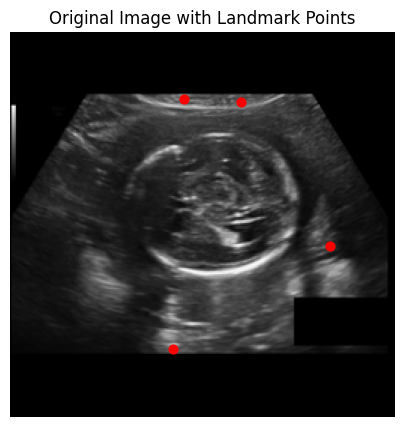

heatmap scaled: 


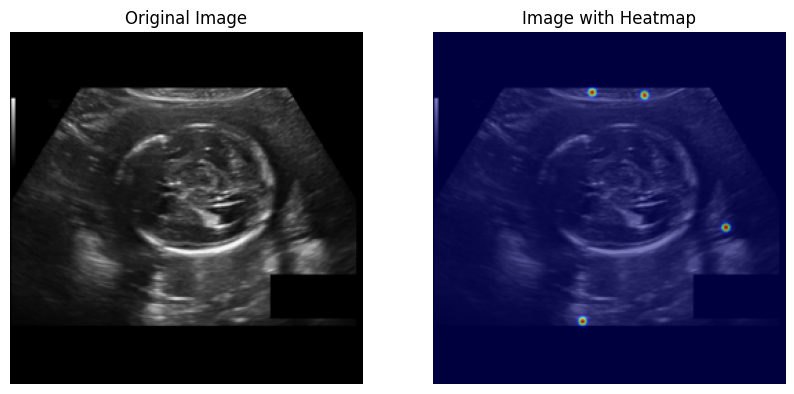

cound:  0 done
original_img.szie:  (780, 544)
resized_image.size:  (256, 256)
new_width (inside scale_cooords):  256 new)height:(inside_scale_coords)  179
target_size:  (256, 256)
inside heatmap, shape:  (256, 256)
initiallly, heatmap.size:  65536
resized and scaled: 


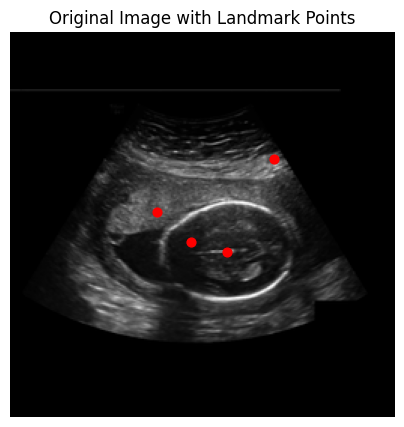

heatmap scaled: 


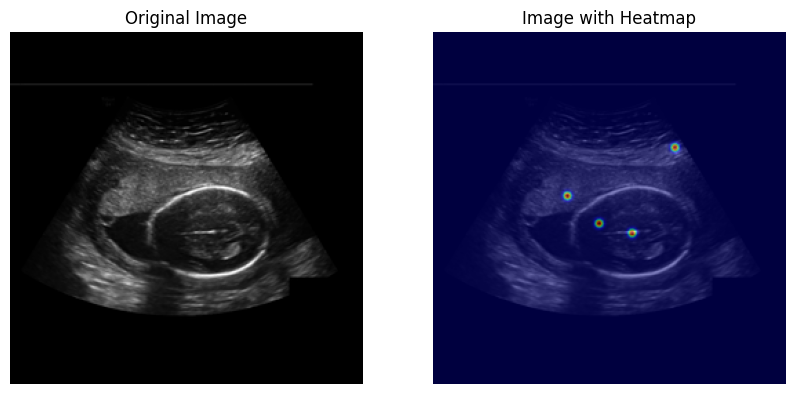

cound:  1 done
original_img.szie:  (800, 540)
resized_image.size:  (256, 256)
new_width (inside scale_cooords):  256 new)height:(inside_scale_coords)  173
target_size:  (256, 256)
inside heatmap, shape:  (256, 256)
initiallly, heatmap.size:  65536
resized and scaled: 


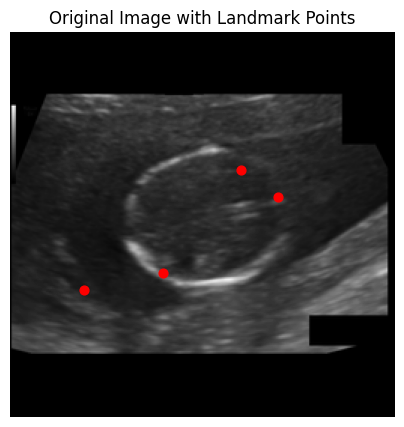

heatmap scaled: 


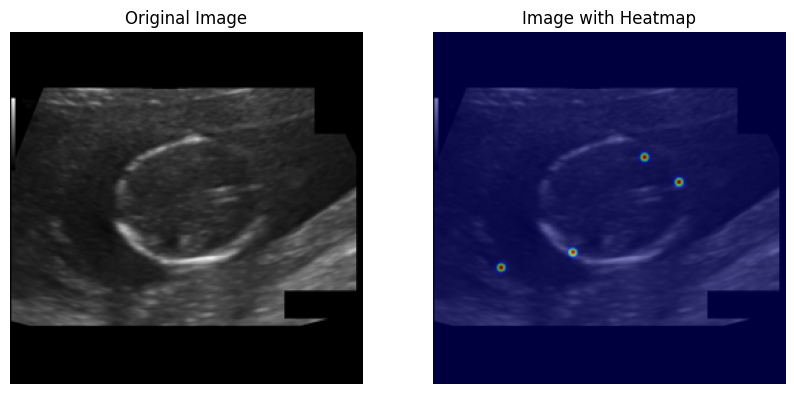

cound:  2 done


In [20]:
#this works
base_path = '/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/'
image_paths = os.listdir(base_path) 
count = 0
for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        if count == 3: 
                break
        full_path = os.path.join(base_path, image_path) 
        with Image.open(full_path).convert('L') as img:
                print('original_img.szie: ', img.size)
                target_size = (256, 256) 
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                print('resized_image.size: ', resized_image.size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                #visualize heatmap for 3 counts 
                # print('original: ')
                # visualize_individual_points(np.array(img), coordinates)
                print('resized and scaled: ')
                visualize_individual_points(np.array(resized_image), scaled_coordinates)
                print('heatmap scaled: ')
                visualize_image_and_heatmap(resized_image, scaled_heatmap) 
                print('cound: ', count, 'done')
                count += 1

In [27]:
base_path = '/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/'
image_paths = os.listdir(base_path) 
feature_dictionary = {'image': [], 'heatmap': []}

for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        full_path = os.path.join(base_path, image_path) 
        with Image.open(full_path).convert('L') as img:
                target_size = (256, 256) 
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                #  Store the resized image and heatmap in the feature dictionary
                feature_dictionary['image'].append(np.array(resized_image) / 255.0)  # Normalize the pixel values
                feature_dictionary['heatmap'].append(scaled_heatmap)

/tmp/ipykernel_4842/3280817827.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


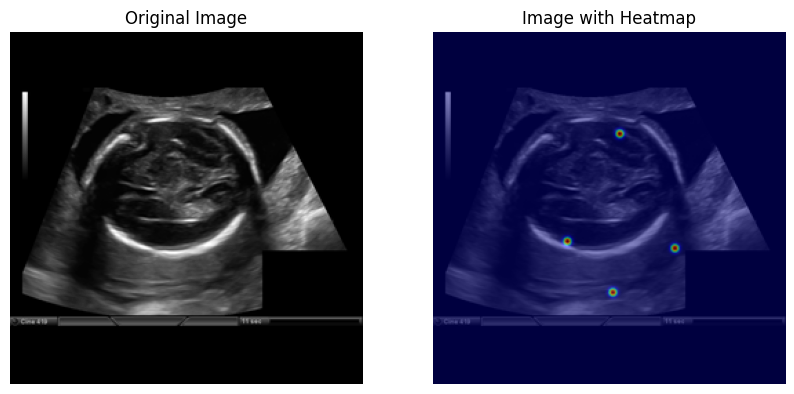

In [28]:
#take a random iimage and corresponding heatmap from  feature_dictionary and plot it 
ran_img = feature_dictionary['image'][3] 
ran_heatmap = feature_dictionary['heatmap'][3]
visualize_image_and_heatmap(ran_img, ran_heatmap)

original_img.shape:  (800, 540)
resized_img.shape:  (256, 256)
new_width:  256 new)height:  173
target_size:  (256, 256)


/tmp/ipykernel_32452/2517099563.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


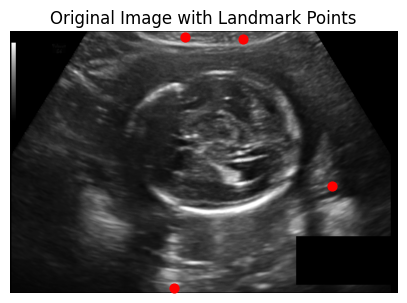

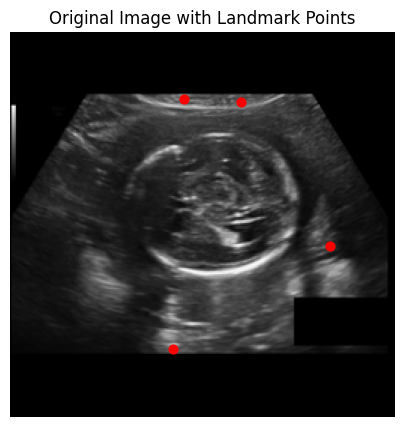

count: 0 done
original_img.shape:  (780, 544)
resized_img.shape:  (256, 256)
new_width:  256 new)height:  179
target_size:  (256, 256)


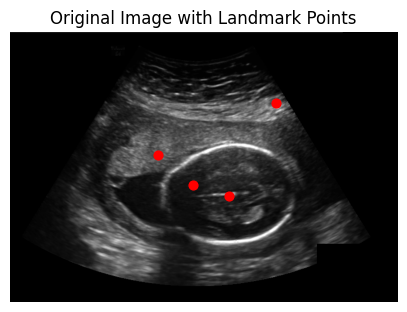

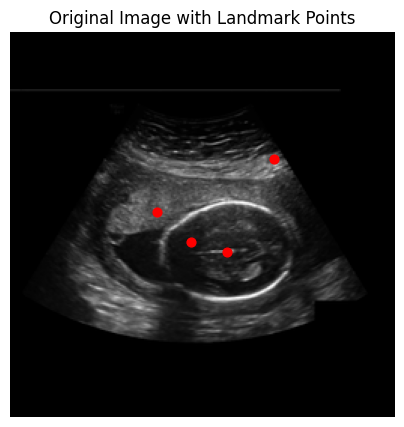

count: 1 done
original_img.shape:  (800, 540)
resized_img.shape:  (256, 256)
new_width:  256 new)height:  173
target_size:  (256, 256)


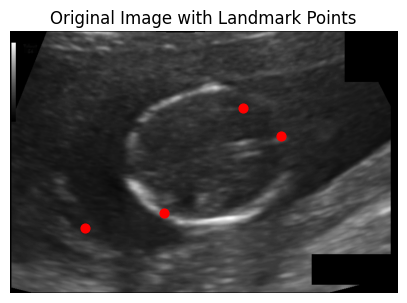

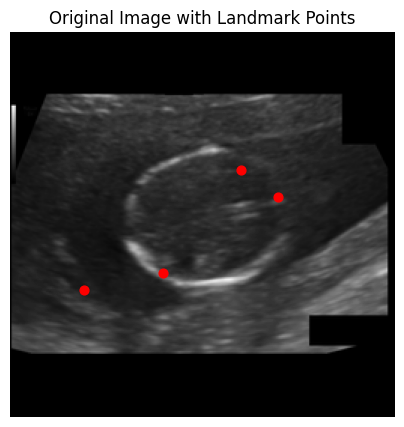

count: 2 done


In [10]:
# #works for visualization 
base_path = '/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/'
image_paths = os.listdir(base_path) 
count = 0
for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        if count == 3: 
                break
        full_path = os.path.join(base_path, image_path) 
        with Image.open(full_path).convert('L') as img:
                print('original_img.shape: ', img.size)
                target_size = (256, 256) 
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                print('resized_img.shape: ', resized_image.size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                visualize_individual_points(img, coordinates)
                visualize_individual_points(resized_image, scaled_coordinates)
                print('count: {} done'.format(count))
                count += 1
                

/tmp/ipykernel_30609/565267332.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


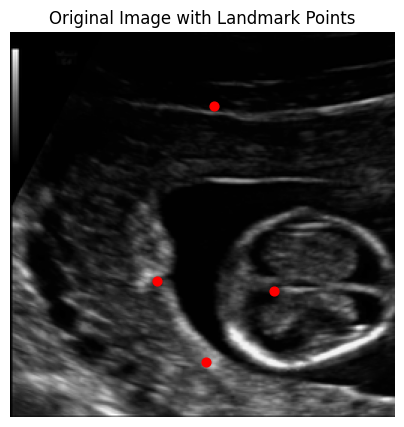

In [16]:
# #doesn't work
# from PIL import Image

# def resize_image_with_aspect_ratio(image, target_size):
#     original_ratio = max(image.size) / min(image.size)
#     target_ratio = max(target_size) / min(target_size)
    
#     if original_ratio > target_ratio:
#         # The original image is wider than the target size
#         new_height = min(target_size)
#         new_width = int(new_height * original_ratio)
#     else:
#         # The original image is taller than the target size
#         new_width = min(target_size)
#         new_height = int(new_width / original_ratio)

#     resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
    
#     # Add padding if necessary to achieve the target size
#     padding_width = max(target_size[0] - new_width, 0)
#     padding_height = max(target_size[1] - new_height, 0)
    
#     # Apply padding equally on both sides
#     left_padding = padding_width // 2
#     top_padding = padding_height // 2
#     right_padding = padding_width - left_padding
#     bottom_padding = padding_height - top_padding
    
#     padded_image = Image.new("L", target_size, color=0)
#     padded_image.paste(resized_image, (left_padding, top_padding))
    
#     return padded_image, (left_padding, top_padding)

# def scale_coordinates(coords, original_shape, padding, target_size):
#     # Normalize the coordinates
#     normalized_coords = [(x / original_shape[0], y / original_shape[1]) for x, y in coords]
    
#     # Scale the normalized coordinates to the target size
#     scaled_coords = [(int(x * target_size[0] + padding[0]), int(y * target_size[1] + padding[1])) for x, y in normalized_coords]
    
#     return scaled_coords
# # <---------------------------------------------------------------------------->
# def my_normalize_coordinates(coordinates, image_size):
#     normalized_coords = [(x / image_size[0], y / image_size[1]) for x, y in coordinates]
#     return normalized_coords

# def my_scale_coordinates(norm_coords, image_size, padding = None):
#     # scaled_coords = [(int(x * image_size[0]), int(y * image_size[1])) for x, y in norm_coords]
#     #or try: 
#     scaled_coords = [(int(x * image_size[0] + padding[0]), int(y * image_size[1] + padding[1])) for x, y in norm_coords]
#     return scaled_coords

# # <------------------------------------------------------------------------------->
# # Example usage
# original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/003_HC.png').convert('L')
# target_size = (256, 256)  # The desired output size

# # Resize image and get padding offsets
# resized_and_padded_image, padding_offsets = resize_image_with_aspect_ratio(original_image, target_size)

# # Assume we have coordinates for bounding boxes
# original_coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]
# # <---------------------------------------------------------------------------------------------->
# norm_coordinates = my_normalize_coordinates(original_coordinates, original_image.size)#here we pass original size
# scaled_coordinates = my_scale_coordinates(norm_coordinates, target_size, padding_offsets) 
# visualize_individual_points(resized_and_padded_image, scaled_coordinates)
# # <---------------------------------------------------------------------------------------------->
# # Scale the coordinates to the resized image
# # scaled_coordinates = scale_coordinates(original_coordinates, original_image.size, padding_offsets, target_size)
# # visualize_individual_points(resized_and_padded_image, scaled_coordinates)

In [36]:
#this is wrong 
# def scale(coords, original_shape, new_shape): 
#     x_scale = new_shape[1] / original_shape[1]
#     y_scale = new_shape[0] / original_shape[0]
#     scaled_coords = [] 
#     for x, y in coords: 
#         scaled_x = int(x * x_scale)
#         scaled_y = int(y * y_scale) 
#         scaled_x = min(scaled_x, new_shape[1] -1) 
#         scaled_y = min(scaled_y, new_shape[0] - 1)
#         scaled_coords.append((scaled_x, scaled_y))
#     return scaled_coords

# def process_image(image_paths, all_coordinates, base_path): 
#     feature_dictionary = {'image': [], 'heatmap': []}
#     image_shape = (256, 256)
#     for image_path, coordinates in zip(image_paths, all_coordinates): 
#         full_path = os.path.join(base_path, image_path) 
#         with Image.open(full_path).convert('L') as img: #l is for grayscale mode
#             original_shape = img.size
#             img_resized = img.resize((256, 256)) 
#             image = np.array(img_resized)/ 255.0 #normalizing 
#             #scale the coordinates to size of iamge
#             try:
#                 scaled_coordinates = scale(coordinates, original_shape, image_shape)
#                 heatmap = create_heatmap(scaled_coordinates, image_shape)
#             except: 
#                 print('original_shape: ', original_shape)
#                 print('orginal_coordinates: ', coordinates)
#                 print('scaled_coordiantes: ', scaled_coordinates)
#                 break
#             feature_dictionary['image'].append(image) #saving processed image 
#             feature_dictionary['heatmap'].append(heatmap)
#     return feature_dictionary

# base_path = '/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/'
# image_paths = os.listdir(base_path) 
# processed_data = process_image(image_paths, all_coordinates, base_path)

In [29]:
#doesn't work , another failed attempt 
# import matplotlib.pyplot as plt
# from PIL import ImageOps

# def temp_scale(coords, original_shape, target_shape):
#     # Calculate scale factors, maintaining aspect ratio
#     original_aspect = original_shape[0] / original_shape[1]
#     target_aspect = target_shape[0] / target_shape[1]

#     if original_aspect > target_aspect:
#         # Original is taller
#         scale_factor = target_shape[1] / original_shape[1]
#         y_offset = (target_shape[0] - (original_shape[0] * scale_factor)) / 2
#         x_offset = 0
#     else:
#         # Original is wider
#         scale_factor = target_shape[0] / original_shape[0]
#         x_offset = (target_shape[1] - (original_shape[1] * scale_factor)) / 2
#         y_offset = 0
    
#     return [(int(x * scale_factor + x_offset), int(y * scale_factor + y_offset)) for x, y in coords]
# def temp2_scale(coords, original_shape, target_shape):
#     # Determine scale factors
#     x_scale = target_shape[1] / original_shape[1]
#     y_scale = target_shape[0] / original_shape[0]

#     # Find the smaller scale factor
#     scale_factor = min(x_scale, y_scale)

#     # Apply the scale factor
#     scaled_coords = [(int(x * scale_factor), int(y * scale_factor)) for x, y in coords]

#     # Calculate padding if the aspect ratio is preserved
#     pad_x = (target_shape[1] - (original_shape[1] * scale_factor)) // 2
#     pad_y = (target_shape[0] - (original_shape[0] * scale_factor)) // 2

#     # Add padding offset to the coordinates
#     padded_coords = [(x + pad_x, y + pad_y) for x, y in scaled_coords]

#     return padded_coords

# def resize_image_with_aspect_ratio(image, target_shape):
#     # Resize the image, maintaining aspect ratio and padding the rest
#     image.thumbnail(target_shape, Image.ANTIALIAS)
#     delta_w = target_shape[1] - image.size[0]
#     delta_h = target_shape[0] - image.size[1]
#     padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
#     new_image = ImageOps.expand(image, padding)
#     return new_image

# def visualize_individual_points(image, coordinates):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image, cmap='gray')
#     for x, y in coordinates:
#         plt.scatter([x], [y], c='r', s=40)
#     plt.title("Original Image with Landmark Points")
#     plt.axis('off')
#     plt.show()
# def visualize_heatmap_overlay(image, heatmap):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image, cmap='gray', interpolation='none')
#     plt.imshow(heatmap, cmap='jet', alpha=0.5, interpolation='none')  # Overlay heatmap
#     plt.title("Image with Heatmap Overlay")
#     plt.axis('off')
#     plt.show()
# # Example usage
# # Assuming 'image' is the original image and 'coordinates' is the list of scaled coordinates
# original_image = Image.open('/home/shilpi_fire/Documents/Kaggle/RoleChallengeOrignMedical/images/005_HC.png').convert('L')
# print('original_image.size: ', original_image.size) 
# img_resized = resize_image_with_aspect_ratio(original_image, (256, 256))
# print('resized shape ', img_resized.size)
# image = np.array(img_resized)/ 255.0
# scaled_coordinates = temp2_scale(all_coordinates[5], original_image.size, (256, 256))
# # heatmap = create_heatmap(scaled_coordinates, image.size)
# visualize_individual_points(image, scaled_coordinates)
# # visualize_heatmap_overlay(image, heatmap)


<b> Now we've our training data in the form of feature_dictionary, which contains image and it's corresponding heatmap. </b>

In [30]:
#get a basic unet architecture, but split the dataset first 
from sklearn.model_selection import train_test_split
X = np.array(feature_dictionary['image'])
y = np.array(feature_dictionary['heatmap'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

497 125
497 125


In [35]:
X_train.shape #so we've 497 images of shape 256x256

(497, 256, 256)

In [36]:
y_train.shape #and corresponding to that, we've 497 heatmaps same size as image.

(497, 256, 256)

In [37]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [38]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

SEED = 1 
# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Normalize pixel values if not already done so during preprocessing
mean, std = 0.5, 0.5  # These are standard values for normalization, adjust if necessary
X_train_normalized = (X_train_tensor - mean) / std
X_test_normalized = (X_test_tensor - mean) / std

# Create TensorDataset
train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

# CUDA check
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Create DataLoaders
train_loader = DataLoader(train_dataset, **dataloader_args)
test_loader = DataLoader(test_dataset, **dataloader_args)

/home/shilpi_fire/colab/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/shilpi_fire/colab/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


CUDA Available? False


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.down1 = CBR(1, 64)
        self.down2 = CBR(64, 128)
        self.down3 = CBR(128, 256)
        self.down4 = CBR(256, 512)

        self.maxpool = nn.MaxPool2d(2)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.conv_up3 = CBR(512, 256)
        self.conv_up2 = CBR(256, 128)
        self.conv_up1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Downsample
        x1 = self.down1(x)
        p1 = self.maxpool(x1)

        x2 = self.down2(p1)
        p2 = self.maxpool(x2)

        x3 = self.down3(p2)
        p3 = self.maxpool(x3)

        x4 = self.down4(p3)

        # Upsample
        u3 = self.up3(x4)
        u3 = torch.cat((u3, x3), dim=1)
        u3 = self.conv_up3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat((u2, x2), dim=1)
        u2 = self.conv_up2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat((u1, x1), dim=1)
        u1 = self.conv_up1(u1)

        # Final output
        out = self.final(u1)
        return out
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = UNet().to(device)
summary(model, input_size=(1, 32, 32)) # 7 million parameters model

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1

In [ ]:
from tqdm import tqdm 
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = [] 
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
  
def train(model, device, train_loader, optimizer, scheduler, criterion): #adding scheduler and criterion
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))                           #adding extra line

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()                                        #adding extra line

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

                                                            #adding get_lr function below
    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):            #added criterion here
    model.eval()
    test_loss = 0
    correct = 0
    # misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim = True)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target.view_as(pred)).sum().item()        #modified this line
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return Accuracy

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'max', patience = 20)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, criterion) #adding criterion as argument
    Accuracy = test(model, device, test_loader, criterion) 
    scheduler.step(Accuracy) 

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)
        self.up1 = DoubleConv(1024, 256)
        self.up2 = DoubleConv(512, 128)
        self.up3 = DoubleConv(256, 64)
        self.up4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(torch.cat([x5, x4], dim=1))
        x = self.up2(torch.cat([x, x3], dim=1))
        x = self.up3(torch.cat([x, x2], dim=1))
        x = self.up4(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits

# Example of using the U-Net
model = UNet(n_channels=1, n_classes=2)  # n_classes is the number of classes in your segmentation task
